In [1]:
'''Deploy cross-node communication measuring pods'''

from kubernetes import client, config

def check_pods_existence(namespace):
    core_v1 = client.CoreV1Api()
    try:
        pods = core_v1.list_namespaced_pod(namespace=namespace)
        return len(pods.items) > 0 # return True
    except client.rest.ApiException as e:
        print(f"Exception when calling CoreV1Api->list_namespaced_pod: {e}")
        return False

def deploy_latency_measurement_daemonset_if_needed():
    namespace = 'measure-nodes'
    ds_name = 'latency-measurement-ds'
    
    # Assuming config and apps_v1 have been defined as before
    config.load_kube_config()
    apps_v1 = client.AppsV1Api()

    # Check if pods exist in the namespace
    pods_exist = check_pods_existence(namespace)

    # If no pods exist, deploy the DaemonSet
    if not pods_exist:
        # Define the body of the DaemonSet
        ds_body = client.V1DaemonSet(
            api_version="apps/v1",
            kind="DaemonSet",
            metadata=client.V1ObjectMeta(name=ds_name),
            spec=client.V1DaemonSetSpec(
                selector=client.V1LabelSelector(
                    match_labels={"app": "latency-measurement"}
                ),
                template=client.V1PodTemplateSpec(
                    metadata=client.V1ObjectMeta(labels={"app": "latency-measurement"}),
                    spec=client.V1PodSpec(
                        containers=[client.V1Container(
                            name="latency-container",
                            image="curlimages/curl",
                            security_context=client.V1SecurityContext(
                                capabilities=client.V1Capabilities(
                                    add=["NET_RAW"]  # Required for ping
                                )
                            )
                        )],
                        restart_policy="Always"
                    )
                )
            )
        )

        # Deploy the DaemonSet
        try:
            apps_v1.create_namespaced_daemon_set(namespace=namespace, body=ds_body)
            print(f"Deployed DaemonSet {ds_name} in namespace {namespace}")
        except client.rest.ApiException as e:
            print(f"Exception when calling AppsV1Api->create_namespaced_daemon_set: {e}")
    else:
        print("Pods already exist in the namespace. Skipping DaemonSet deployment.")

# Call the function to deploy the DaemonSet if needed
deploy_latency_measurement_daemonset_if_needed()



Pods already exist in the namespace. Skipping DaemonSet deployment.


In [8]:
'''using the measuring pods to meaure node-node communication delays'''

from kubernetes import client, config, stream


def measure_http_latency(namespace='measure-nodes'):
    v1 = client.CoreV1Api()
    pods = v1.list_namespaced_pod(namespace, label_selector="app=latency-measurement").items
    # pods = ['k8s-worker-1','k8s-worker-2', 'k8s-worker-3', 'k8s-worker-4', 'k8s-worker-5', 'k8s-worker-6',
    #         'k8s-worker-7', 'k8s-worker-8', 'k8s-worker-9']
    latency_results = {}
    
    for source_pod in pods: # the source pod/node that sending cURL requests
        source_pod_name = source_pod.metadata.name
        source_pod_node_name =  source_pod.spec.node_name
        latency_results[source_pod_node_name] = {}
        
        for target_pod in pods: # the target pod/node that receiving cURL request
            target_pod_ip = target_pod.status.pod_ip
            target_pod_name = target_pod.metadata.name
            target_pod_node_name = target_pod.spec.node_name
            if source_pod_name != target_pod_name:
                # execuation of cURL command
                exec_command = ['curl', '-o', '/dev/null', '-s', '-w', '%{time_total}', f'http://{target_pod_ip}']
                try:
                    resp = stream.stream(v1.connect_get_namespaced_pod_exec,
                                         source_pod_name,
                                         namespace,
                                         command=exec_command,
                                         stderr=True,
                                         stdin=False,
                                         stdout=True,
                                         tty=False)
                    #print(f"Latency from {source_pod_name} on node {source_pod.spec.node_name} to {target_pod_ip} on target node {target_pod.spec.node_name}: {resp} seconds")
                    print(f"Latency from source node {source_pod.spec.node_name} to target node {target_pod.spec.node_name}: {float(resp)*1000} mill seconds")

                    latency_results[source_pod.spec.node_name][target_pod_node_name] = float(resp)*1000
                except Exception as e:
                    print(f"Error executing command in pod {source_pod_name}: {e}")
                    latency_results[source_pod.spec.node_name][target_pod_node_name] = "Error"
    return latency_results


# Call the function to measure latency after deploying the DaemonSet
namespace = 'measure-nodes'
#after the DaemonSet is ready, and the realted pods are ready
latency_results = measure_http_latency(namespace=namespace)
print(latency_results)


Latency from source node k8s-worker-3 to target node k8s-worker-9: 1.16 mill seconds
Latency from source node k8s-worker-3 to target node k8s-worker-6: 1.0230000000000001 mill seconds
Latency from source node k8s-worker-3 to target node k8s-worker-7: 25.884 mill seconds
Latency from source node k8s-worker-3 to target node k8s-worker-5: 1.026 mill seconds
Latency from source node k8s-worker-3 to target node k8s-worker-1: 1.436 mill seconds
Latency from source node k8s-worker-3 to target node k8s-worker-2: 1.631 mill seconds
Latency from source node k8s-worker-3 to target node k8s-worker-8: 1.129 mill seconds
Latency from source node k8s-worker-3 to target node k8s-worker-4: 1.341 mill seconds
Latency from source node k8s-worker-9 to target node k8s-worker-3: 0.914 mill seconds
Latency from source node k8s-worker-9 to target node k8s-worker-6: 1.163 mill seconds
Latency from source node k8s-worker-9 to target node k8s-worker-7: 1.9 mill seconds
Latency from source node k8s-worker-9 to ta

In [11]:
import pandas as pd

# Convert the nested dictionary into a pandas DataFrame
df = pd.DataFrame(latency_results)

# Transpose the DataFrame to align the source and destination workers as per convention
df = df.T

# Fill diagonal with 0's for self-latency (optional, if desired for clarity)
for worker in df.columns:
    df.at[worker, worker] = 0

df

,k8s-worker-4,k8s-worker-5,k8s-worker-2,k8s-worker-8,k8s-worker-1,k8s-worker-6,k8s-worker-3,k8s-worker-9,k8s-worker-7
k8s-worker-3,0.928,0.530,1.214,0.988,11.962,0.824,0.000,0.865,1.306
k8s-worker-9,1.014,1.012,1.358,1.456,1.923,1.243,1.347,0.000,1.151
k8s-worker-6,0.837,0.866,1.357,1.053,1.014,0.000,0.885,0.943,0.918
k8s-worker-7,1.036,0.922,0.786,1.587,0.671,1.544,1.370,1.705,0.000
k8s-worker-5,1.109,0.000,1.818,1.347,1.081,0.826,1.273,2.085,1.302
k8s-worker-1,0.605,0.783,0.845,0.867,0.000,1.739,0.587,1.734,0.570
k8s-worker-2,0.601,5.853,0.000,55.777,43.103,1.121,72.611,1.530,0.776
k8s-worker-8,1.233,1.171,1.450,0.000,1.021,1.155,1.102,2.046,0.812
k8s-worker-4,0.000,21.396,0.842,0.781,0.795,4.284,80.347,1.001,1.291


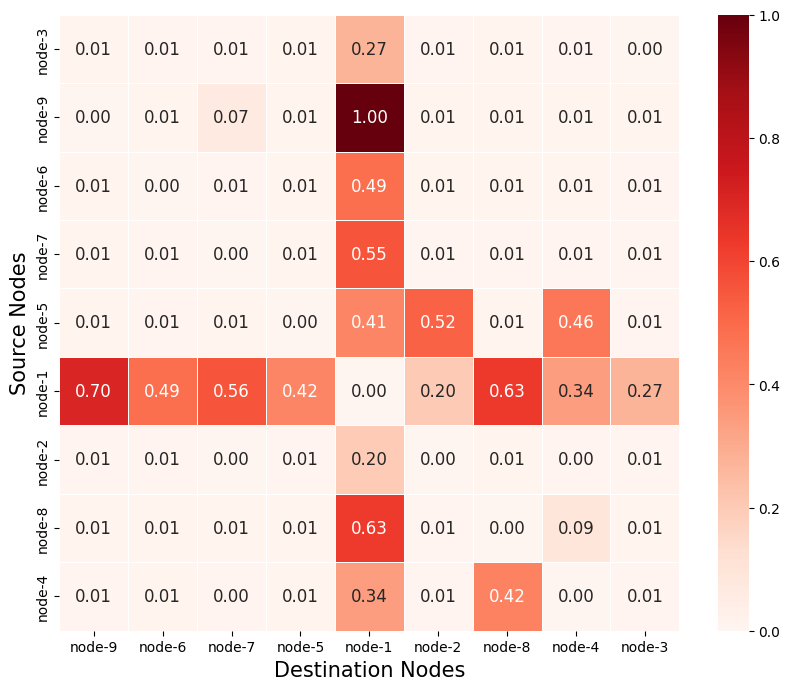

In [16]:
''' Normalize node-node communication delay matrix'''


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Convert the  dictionary into a pandas DataFrame and transpose it
df = pd.DataFrame(latency_results).T

# Mapping old names to new names
worker_node = {
    'k8s-worker-1': 'node-1', 'k8s-worker-2': 'node-2', 'k8s-worker-3': 'node-3',
    'k8s-worker-4': 'node-4', 'k8s-worker-5': 'node-5', 'k8s-worker-6': 'node-6',
    'k8s-worker-7': 'node-7', 'k8s-worker-8': 'node-8', 'k8s-worker-9': 'node-9'
}

# Rename the columns and index according to the dictionary
df.rename(columns=worker_node, index=worker_node, inplace=True)

# Fill diagonal with 0's for self-latency (optional, if desired for clarity)
for worker in df.columns:
    df.at[worker, worker] = 0

# Normalize the DataFrame
max_latency = df.max().max()  # Find the maximum value in the DataFrame
normalized_df = df / max_latency  # Divide every element by the maximum value

# Plot the normalized matrix
plt.figure(figsize=(10, 8))
sns.heatmap(normalized_df, annot=True,  cmap= "Reds",fmt=".2f", annot_kws={'size': 12},xticklabels=True, yticklabels=True, linewidths=.5)
# plt.title('Normalized Latency Matrix')
plt.xlabel('Destination Nodes', fontsize=15)
plt.ylabel('Source Nodes', fontsize=15)
plt.show()


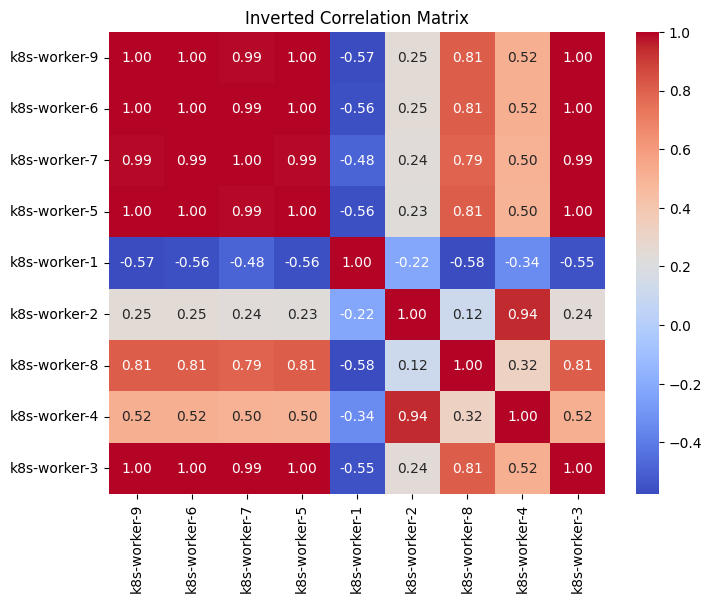

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# k8s-worker --- node
woker_node = {'k8s-worker-1': 'node1', 'k8s-worker-2': 'node2', 'k8s-worker-3': 'node3',
              'k8s-worker-4': 'node4', 'k8s-worker-5': 'node5', 'k8s-worker-6': 'node6',
              'k8s-worker-7': 'node7', 'k8s-worker-8': 'node8', 'k8s-worker-9': 'node9'}



df = pd.DataFrame(latency_results).T
for worker in df.columns:
    df.at[worker, worker] = 0

# Calculate the correlation matrix
corr_matrix = df.corr()

# Invert the correlation matrix
# inverted_corr_matrix =  np.abs(corr_matrix)

# Plot the inverted correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Inverted Correlation Matrix')
plt.show()



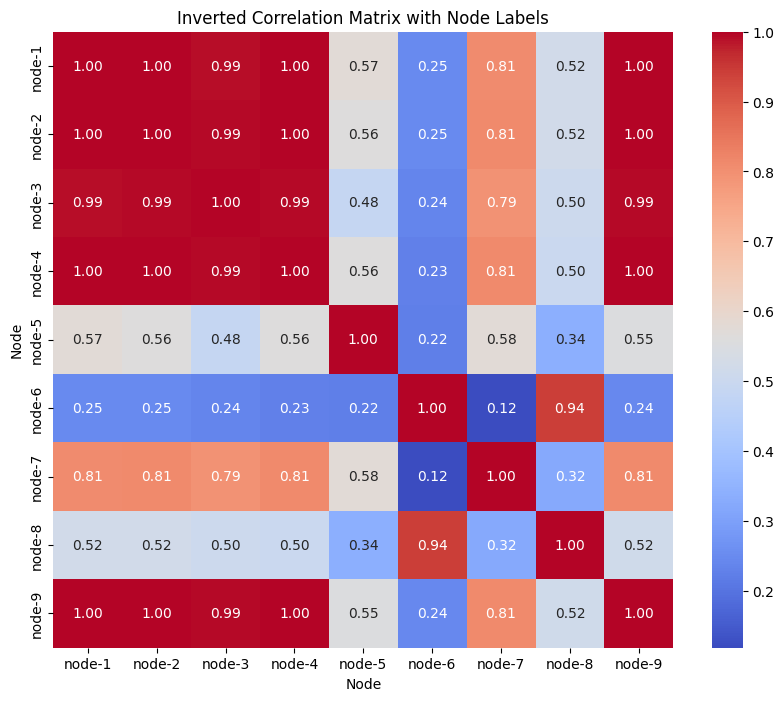

In [18]:
# Convert the nested dictionary into a pandas DataFrame and transpose it
df = pd.DataFrame(latency_results).T

# Fill diagonal with 0's for self-latency
for worker in df.columns:
    df.at[worker, worker] = 0

# Calculate the correlation matrix
corr_matrix = df.corr()

# Dictionary to map old worker names to new names
worker_node = {
    'k8s-worker-1': 'node-1', 'k8s-worker-2': 'node-2', 'k8s-worker-3': 'node-3',
    'k8s-worker-4': 'node-4', 'k8s-worker-5': 'node-5', 'k8s-worker-6': 'node-6',
    'k8s-worker-7': 'node-7', 'k8s-worker-8': 'node-8', 'k8s-worker-9': 'node-9'
}

# Rename the columns and index of the correlation matrix for visualization
renamed_corr_matrix = corr_matrix.rename(columns=worker_node, index=worker_node)

# Take the absolute value of the correlation matrix to invert it
inverted_renamed_corr_matrix = np.abs(renamed_corr_matrix)

# Plot the inverted correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(inverted_renamed_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=worker_node.values(), yticklabels=worker_node.values())
plt.title('Inverted Correlation Matrix with Node Labels')
plt.xlabel('Node')
plt.ylabel('Node')
plt.show()